In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class agent:
    def __init__(self, index, race, position):
        self.index = index
        self.race = race # 1 = black, 0 = white
        self.position = position

    def choose_neighborhoob(self, lattice):
        available_neighborhoobs = [*lattice.vacant_positions, self.position] # k
        probabilities = []

        same_race_proportion = np.append(lattice.black_ratio_in_vacant, lattice.get_black_ratio(self.position))
        if self.race == 0: # The agent is white
            same_race_proportion = 1 - same_race_proportion
        same_race_proportion[same_race_proportion > 1] = 0
        same_race_proportion[same_race_proportion < 0] = 0
        
        if lattice.choice_function == "Schelling":
            probabilities = (same_race_proportion >= lattice.threshold) + 0 
            probabilities = probabilities / sum(probabilities)
       
        elif lattice.choice_function == "Non-Zero":
            probabilities = (same_race_proportion >= lattice.threshold) + 0
            probabilities = np.exp(probabilities)
            probabilities = probabilities / sum(probabilities)

        elif lattice.choice_function == "Staircase": 
            probabilities = np.floor(same_race_proportion/0.1) * 0.1
            probabilities = np.exp(probabilities)
            probabilities = probabilities / sum(probabilities)

        elif lattice.choice_function == "Continuous":
            probabilities = np.exp(same_race_proportion)
            probabilities = probabilities / sum(probabilities)
        
        else:
            print("Wrong Choice Function!")

        destination = random.choices(available_neighborhoobs, weights=probabilities, k=1)[0]
        self.position = destination
        return destination

class lattice:
    def __init__(self, size, choice_function, threshold=0.5, tract_length=10):
        self.size = size
        self.agent_num = int((size**2)*0.85)
        self.vacant_num = int((size**2)*0.15)
        self.tract_length = tract_length # Default: length of each tract = 10 (size = 100)
        self.tract_num = int((self.size/tract_length)**2) 
        self.choice_function = choice_function
        self.threshold = threshold
        self.t = 0

        self.agents = [] # List storing agent objects
        self.map = np.full((self.size, self.size), -1) # 2D array recording each position populated by which agent 
        self.vacant_positions = [] # List storing vacant positions

        # 初始行動者位置
        positions_in_each_tract = [list() for i in range(self.tract_num)]
        for i in range(self.size**2):
            tract_index = self.to_tract_index(i)
            positions_in_each_tract[tract_index].append(i)
        for i in range(self.tract_num):
            random.shuffle(positions_in_each_tract[i])

        put_vacant_in_which_tract = random.sample([i for i in range(self.tract_num) for j in range(int(self.tract_length**2/2))], k=int(self.vacant_num/2))
        for tract in put_vacant_in_which_tract:
            vacant = positions_in_each_tract[tract][:2]
            positions_in_each_tract[tract].remove(vacant[0])
            positions_in_each_tract[tract].remove(vacant[1])
            self.vacant_positions.append(vacant[0])
            self.vacant_positions.append(vacant[1])

        positions = sum(positions_in_each_tract, []) # flatten

        for i in range(self.agent_num):
            position = positions[i]
            x, y = to_coordinate(position, self.size)
            self.map[x][y] = i

            # Decide the agent's race
            race = 0
            # if x%2 == (y+1)%2: 
            if i%2 == 0: 
                race = 1

            self.agents.append(agent(i, race, position))

        # List storing every position's neighborhood
        self.neighborhoods = []
        for p in range(size**2):
            x, y = to_coordinate(p, size)
            neighbors = []
            for i in range(-2, 3):
                for j in range(-2, 3):  
                    if x+i >= 0 and x+i < size and y+j >= 0 and y+j < size and not (i == 0 and j == 0):
                        neighbor = from_coordinate(x+i, y+j, size)
                        neighbors.append(neighbor)
            self.neighborhoods.append(neighbors)

        # Array storing proportion of black in each vacant position's neighborhood
        self.black_ratio_in_vacant = np.array([self.get_black_ratio(p) for p in self.vacant_positions])

        # Calculate number of black and white in every tract
        self.Nb = sum([a.race for a in self.agents]) # Total number of black
        self.Nw = self.agent_num - self.Nb # Total number of white
        
        # Arrays storing number of black/white ini each tract
        self.Nb_in_each_tract = np.full(self.tract_num, 0) 
        self.Nw_in_each_tract = np.full(self.tract_num, 0)

        for a in self.agents:
            tract_index = self.to_tract_index(a.position)
            if a.race == 1:
                self.Nb_in_each_tract[tract_index] += 1
            else:
                self.Nw_in_each_tract[tract_index] += 1

    def get_black_ratio(self, position):
        neighborhood = self.neighborhoods[position]
        agent_in_neighborhood = []
        for p in neighborhood:
            x, y = to_coordinate(p, self.size)
            agent_in_neighborhood.append(self.map[x][y])
        agent_in_neighborhood = [a for a in agent_in_neighborhood if a != -1]

        if len(agent_in_neighborhood) != 0:
            return sum([self.agents[a].race for a in agent_in_neighborhood]) / len(agent_in_neighborhood)
        else:
            return -1
    
    def to_tract_index(self, positoin):
        x, y = to_coordinate(positoin, self.size)
        return from_coordinate(int(x/self.tract_length), int(y/self.tract_length), int(self.size/self.tract_length))
    
    def one_round(self):
        self.t += 1
        
        # Randomly choose an agent and let him choose next round position based on choice function
        sampled_agent_index = random.randrange(self.agent_num)
        previous_position = self.agents[sampled_agent_index].position
        destination = self.agents[sampled_agent_index].choose_neighborhoob(self)
        
        if destination != previous_position:
            # Update map
            x0, y0 = to_coordinate(previous_position, self.size)
            self.map[x0][y0] = -1
            x1, y1 = to_coordinate(destination, self.size)
            self.map[x1][y1] = self.agents[sampled_agent_index].index

            # Update vacant positions
            destination_index = self.vacant_positions.index(destination)
            self.vacant_positions[destination_index] = previous_position
            
            # Update proportion of black in vacant positions affected in this round
            self.black_ratio_in_vacant[destination_index] = self.get_black_ratio(previous_position)
            for p in self.neighborhoods[destination]:
                if p in self.vacant_positions:
                    p_index = self.vacant_positions.index(p)
                    self.black_ratio_in_vacant[p_index] = self.get_black_ratio(p)

            # Update number of black & white in tracts
            previous_tract = self.to_tract_index(previous_position)
            destination_tract = self.to_tract_index(destination)
            if self.agents[sampled_agent_index].race == 1:
                self.Nb_in_each_tract[previous_tract] -= 1
                self.Nb_in_each_tract[destination_tract] += 1
            else:
                self.Nw_in_each_tract[previous_tract] -= 1
                self.Nw_in_each_tract[destination_tract] += 1

    def get_dissimilarity(self):
        return sum(abs(self.Nb_in_each_tract/self.Nb - self.Nw_in_each_tract/self.Nw)) / 2 

    def plot(self, plot_name="", tick_num=10, show_grid=False):
        map_race = np.full((self.size, self.size), -1)
        for i in range(self.agent_num):
            x, y =  to_coordinate(self.agents[i].position, self.size)
            map_race[x, y] = self.agents[i].race
            
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        cmap = colors.ListedColormap(['white', 'navajowhite', 'midnightblue'])
        plt.pcolormesh(map_race, cmap=cmap, alpha = 0.8, vmin=-1, vmax=1) 
        ax = plt.gca()
        ax.set_xticks(np.arange(0, self.size+1, max(1, int(self.size/tick_num))))
        ax.set_yticks(np.arange(0, self.size+1, max(1, int(self.size/tick_num))))
        fig.set_facecolor('white')
        if show_grid:
            ax.grid(c='black', linestyle='-', linewidth=.75, alpha=.75)
        if plot_name == "":
            plt.show()
        else:
            plt.savefig(plot_name+".png")

def to_coordinate(i, col):
    return int(i/col), i%col

def from_coordinate(x, y, col):
    return x*col+y

In [ ]:
random.seed(16)
Mylattice = lattice(500, 'Schelling') # Schelling, Non-Zero, Staircase, Continuous
print(Mylattice.get_dissimilarity())
Mylattice.plot(plot_name="Test.png", show_grid=True)

In [ ]:
random.seed(16)
Mylattice = lattice(500, 'Schelling') # Schelling, Non-Zero, Staircase, Continuous

# round_num = 10**6
round_num = 10**4

log = []
for round in range(round_num):
    Mylattice.one_round()
    log.append(Mylattice.get_dissimilarity())
    if round % (10**3) == 0:
    # if round % (1) == 0:
        print(round, end=" ")
        # Mylattice.plot()

print(log[-1])
Mylattice.plot()
plt.plot(log)

# Schelling:  0.03838117647058874
# Non-Zero:   0.02714352941176521
# Staircase:  0.027002352941176946
# Continuous: 0.02642823529411814

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.set_xlim([-10**4.35, 10**6.01])
ax.set_ylim([-.015, 0.415])
plt.plot(log, label="Schelling Function")

ax.set_xlabel("ticks (in 10000)", fontsize=12)
ax.set_ylabel("Dissimilarity", rotation=90, y=0.5, fontsize=12)
ax.set_yticks(np.arange(0, 0.41, step=0.04))
ax.set_xticks(np.arange(0, 10**6+1, step=10**5))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x/10000:.2f}'.rstrip('0').rstrip('.'))
ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.2f}'.strip('0') if y != 0 else '0')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins()
fig.set_facecolor('white')
plt.legend()
# plt.savefig('FIG3.jpg')
plt.show()

In [4]:
with open('圖表與結果/data1-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log1 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data2-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log2 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data3-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log3 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data4-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log4 = [float(i) for i in list(data)[0]]

In [8]:
log1[-1]

0.4580988235294117

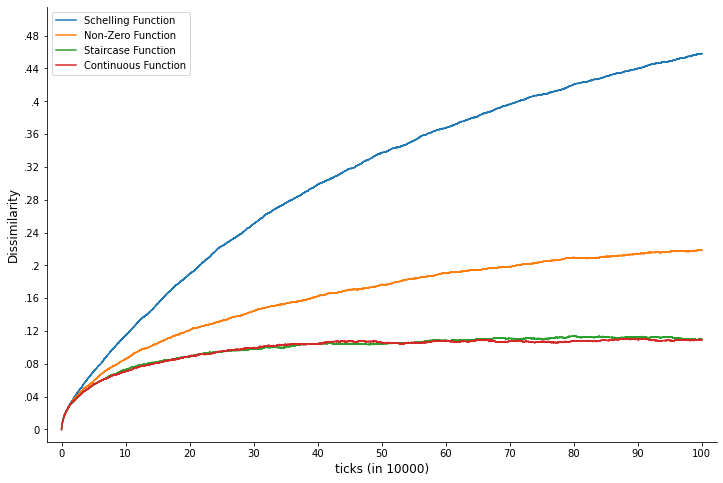

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.set_xlim([-10**4.35, 10**6.01])
ax.set_ylim([-.015, 0.515])
plt.plot(log1, label="Schelling Function")
plt.plot(log2, label="Non-Zero Function")
plt.plot(log3, label="Staircase Function")
plt.plot(log4, label="Continuous Function")

ax.set_xlabel("ticks (in 10000)", fontsize=12)
ax.set_ylabel("Dissimilarity", rotation=90, y=0.5, fontsize=12)
ax.set_yticks(np.arange(0, 0.51, step=0.04))
ax.set_xticks(np.arange(0, 10**6+1, step=10**5))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x/10000:.2f}'.rstrip('0').rstrip('.'))
ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.2f}'.strip('0') if y != 0 else '0')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins()
fig.set_facecolor('white')
plt.legend()
plt.savefig('FIG3.png')
plt.show()

In [2]:
with open('圖表與結果/data5-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log5 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data6-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log6 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data7-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log7 = [float(i) for i in list(data)[0]]
with open('圖表與結果/data8-1.csv') as csvfile:
    data = csv.reader(csvfile)
    log8 = [float(i) for i in list(data)[0]]

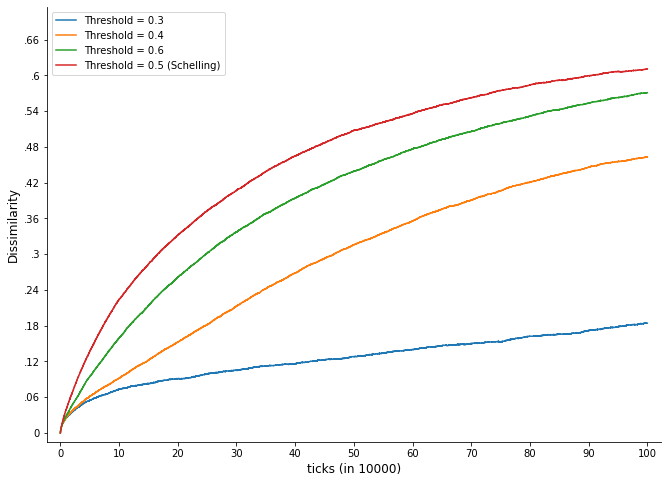

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

ax.set_xlim([-10**4.35, 10**6.01])
ax.set_ylim([-.015, 0.715])
plt.plot(log5, label="Threshold = 0.3")
plt.plot(log6, label="Threshold = 0.4")
plt.plot(log7, label="Threshold = 0.6")
plt.plot(log8, label="Threshold = 0.5 (Schelling)")

ax.set_xlabel("ticks (in 10000)", fontsize=12)
ax.set_ylabel("Dissimilarity", rotation=90, y=0.5, fontsize=12)
ax.set_yticks(np.arange(0, 0.71, step=.06))
ax.set_xticks(np.arange(0, 10**6+1, step=10**5))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x/10000:.2f}'.rstrip('0').rstrip('.'))
ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.2f}'.strip('0') if y != 0 else '0')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins()
fig.set_facecolor('white')
plt.legend()
plt.savefig('FIG7.png')
plt.show()

In [ ]:
Mylattice = lattice(500, 'Staircase')
Mylattice.plot('lattice.png')